In [1]:
import tensorflow as tf
from numpy.random import randint as ri
from time import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def sedghi_max_sinval(conv, inp_shape):
    op = time()
    conv_tr = tf.cast(tf.transpose(conv, perm=[2, 3, 0, 1]), tf.complex128)
    conv_shape = conv.shape
    padding = tf.constant([[0, 0], [0, 0],
                           [0, inp_shape[0] - conv_shape[0]],
                           [0, inp_shape[1] - conv_shape[1]]])
    transform_coeff = tf.signal.fft2d(tf.pad(conv_tr, padding))
    D, U, V = tf.linalg.svd(tf.transpose(transform_coeff, perm=[2, 3, 0, 1]))
    return D.numpy().flatten(), time() - op

In [3]:
def miyato_max_sinval(conv):
    op = time()
    w, h, c0, c2 = conv.shape
    flat_conv = tf.cast(tf.reshape(conv, (-1, c2)), tf.dtypes.complex128)
    D, U, V = tf.linalg.svd(flat_conv)
    return D.numpy(), time() - op

In [4]:
def sinval_dist(axs, r, s, k=3, c0=16, c2=16, n=100, leg=False):
    real_acc, miyato_acc = [], []
    for i in range(n):
        kernel = np.random.normal(0, 1, (k, k, c0, c2))
        real = sedghi_max_sinval(kernel, (16, 16))
        miyato = miyato_max_sinval(kernel)
        real_acc.append(real[0])
        miyato_acc.append(miyato[0])
    real_acc, miyato_acc = np.array(real_acc), np.array(miyato_acc)
    axs.hist(real_acc.flatten(), label='real', alpha=0.6, density=True)
    axs.hist(miyato_acc.flatten(), label='Miyato', alpha=0.6, density=True)
    if r == 0:
        axs.set_title('c_in={}, c_out={}'.format(c0, c2), fontsize=13)
    if s == 0:
        axs.set_ylabel('k={}'.format(k), fontsize=13)
    if r == 0 and s == 0:
        axs.legend()

Random matrices generated from normal distribution

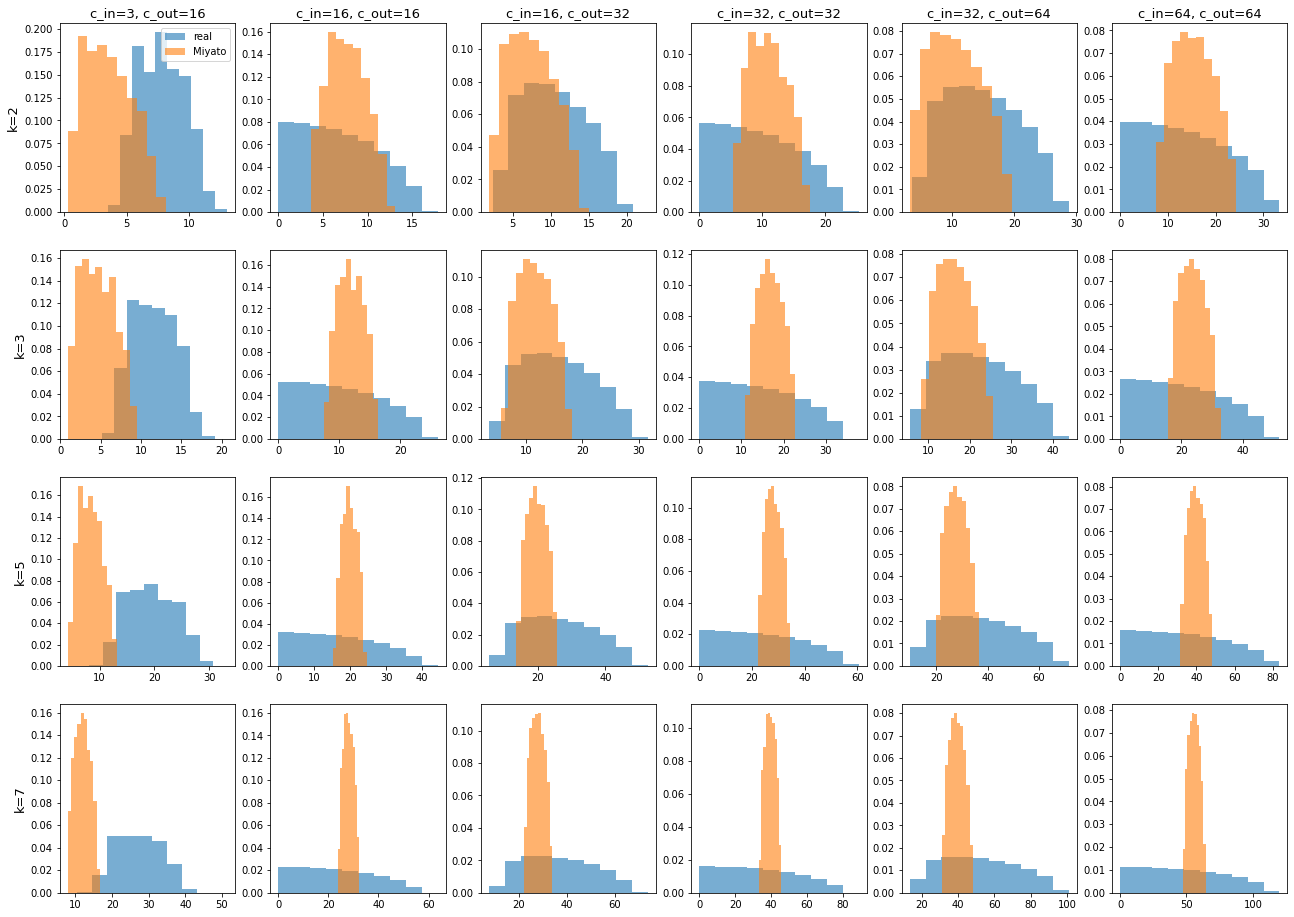

In [ ]:
ks = (2, 3, 5, 7)
cins = (3, 16, 16, 32, 32, 64)
couts = (16, 16, 32, 32, 64, 64)
fig, axs = plt.subplots(len(ks), len(cins), figsize=(22, 16))
for i in range(len(ks)):
    for j in range(len(couts)):
        sinval_dist(axs[i][j], i, j, ks[i], cins[j], couts[j], n=50)

Random matrices with "vanishing" singular values

In [5]:
def dec_matrix(size, base=0.5):
    kernel = np.random.normal(0, 1, size)
    d, u, v = tf.linalg.svd(kernel)
    d_van = tf.reshape([base ** i for i in range(np.prod(d.shape))], d.shape)
    v = tf.cast(v, tf.dtypes.complex128)
    u = tf.cast(u, tf.dtypes.complex128)
    return tf.matmul(u, tf.matmul(tf.linalg.diag(tf.cast(d_van, tf.complex128)), v, adjoint_b=True)).numpy()

In [6]:
def decay(axs, r, s, k, c0, c2, n=100, leg=False):
    inp_len = 16
    miyato_kernel = dec_matrix((k * k * c0, c2))
    kernel = tf.reshape(miyato_kernel, (k, k, c0, c2))
    miyato = miyato_max_sinval(kernel)
    miyato_acc = np.sort(miyato[0])

    real_acc = np.zeros((inp_len * inp_len * min(c2, c0)))
    for i in range(n):
        miyato_kernel = dec_matrix((k * k * c0, c2))
        kernel = tf.reshape(miyato_kernel, (k, k, c0, c2))
        real = sedghi_max_sinval(kernel, (inp_len, inp_len))
        real_acc += np.sort(real[0])
    real_acc /= n
    
    axs.plot(np.linspace(0, 1, len(miyato_acc)), miyato_acc, label='Miyato')
    axs.plot(np.linspace(0, 1, len(real_acc)), real_acc, label='real')
    axs.set_yscale('log')
    if r == 0:
        axs.set_title('c_in={}, c_out={}'.format(c0, c2), fontsize=13)
    if s == 0:
        axs.set_ylabel('k={}'.format(k), fontsize=13)
    if r == 0 and s == 0:
        axs.legend()

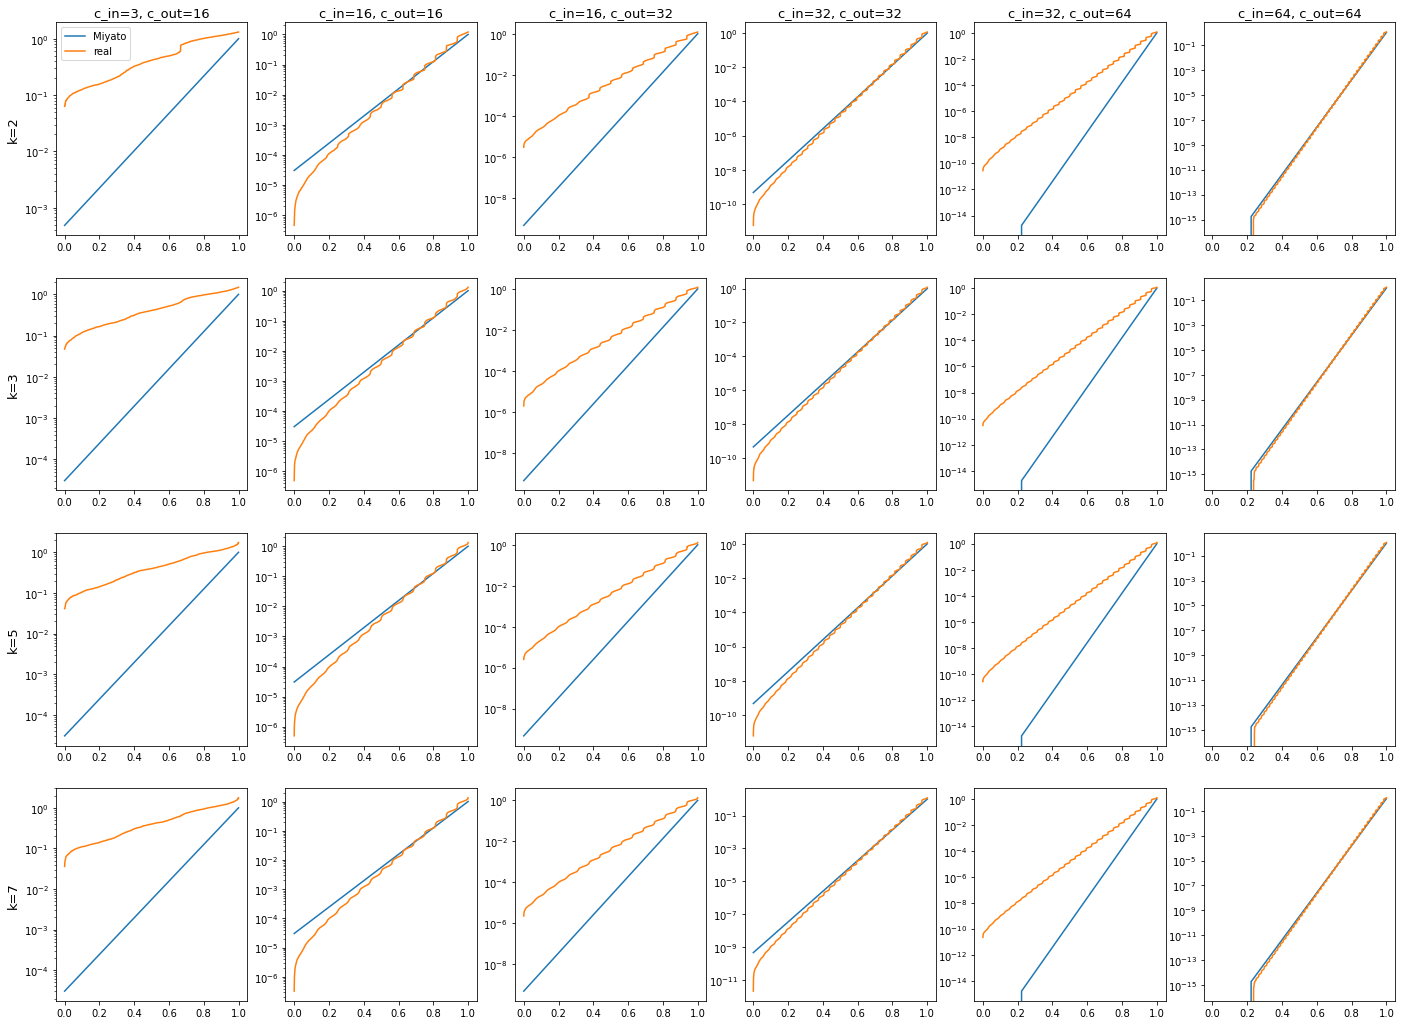

In [ ]:
ks = (2, 3, 5, 7)
cins = (3, 16, 16, 32, 32, 64)
couts = (16, 16, 32, 32, 64, 64)
fig, axs = plt.subplots(len(ks), len(cins), figsize=(24, 18))
for i in range(len(ks)):
    for j in range(len(couts)):
        decay(axs[i][j], i, j, ks[i], cins[j], couts[j], n=5)

Max/min sinvals

In [7]:
def min_max_time_sinvals(axs, r, ks, c0, c2):
    real_mins, real_maxs = [], []
    miyato_mins, miyato_maxs = [], []
    real_times, miyato_times = [], []
    for k in ks:
        real_min, miyato_min = 0, 0
        real_max, miyato_max = 0, 0
        real_time, miyato_time = 0, 0
        n = 20
        for i in range(n):
            kernel = np.random.normal(0, 1, (k, k, c0, c2))
            real = sedghi_max_sinval(kernel, (16, 16))
            miyato = miyato_max_sinval(kernel)
            real_time += real[1]
            miyato_time += miyato[1]
            real_min += np.min(real[0])
            miyato_min += np.min(miyato[0])
            real_max += np.max(real[0])
            miyato_max += np.max(miyato[0])
        real_mins.append(real_min / n)
        miyato_mins.append(miyato_min / n)
        real_maxs.append(real_max / n)
        miyato_maxs.append(miyato_max / n)
        real_times.append(real_time)
        miyato_times.append(miyato_time)
    axs[0].plot(ks, miyato_maxs, label='Miyato max')
    axs[1].plot(ks, miyato_mins, label='Miyato mins')
    axs[2].plot(ks, miyato_times, label='Miyato times')
    axs[0].plot(ks, real_maxs, label='Real max')
    axs[1].plot(ks, real_mins, label='Real mins')
    axs[2].plot(ks, real_times, label='Real times')
    if r == 0:
        for i in range(3):
            axs[i].legend()
        axs[0].set_title('max sin val')
        axs[1].set_title('min sin val')
        axs[2].set_title('time for calculating {} svds'.format(n))
    axs[0].set_ylabel('c_in={}, c_out={}'.format(c0, c2))
    if r == 5:
        for i in range(3):
            axs[i].set_xlabel('k')


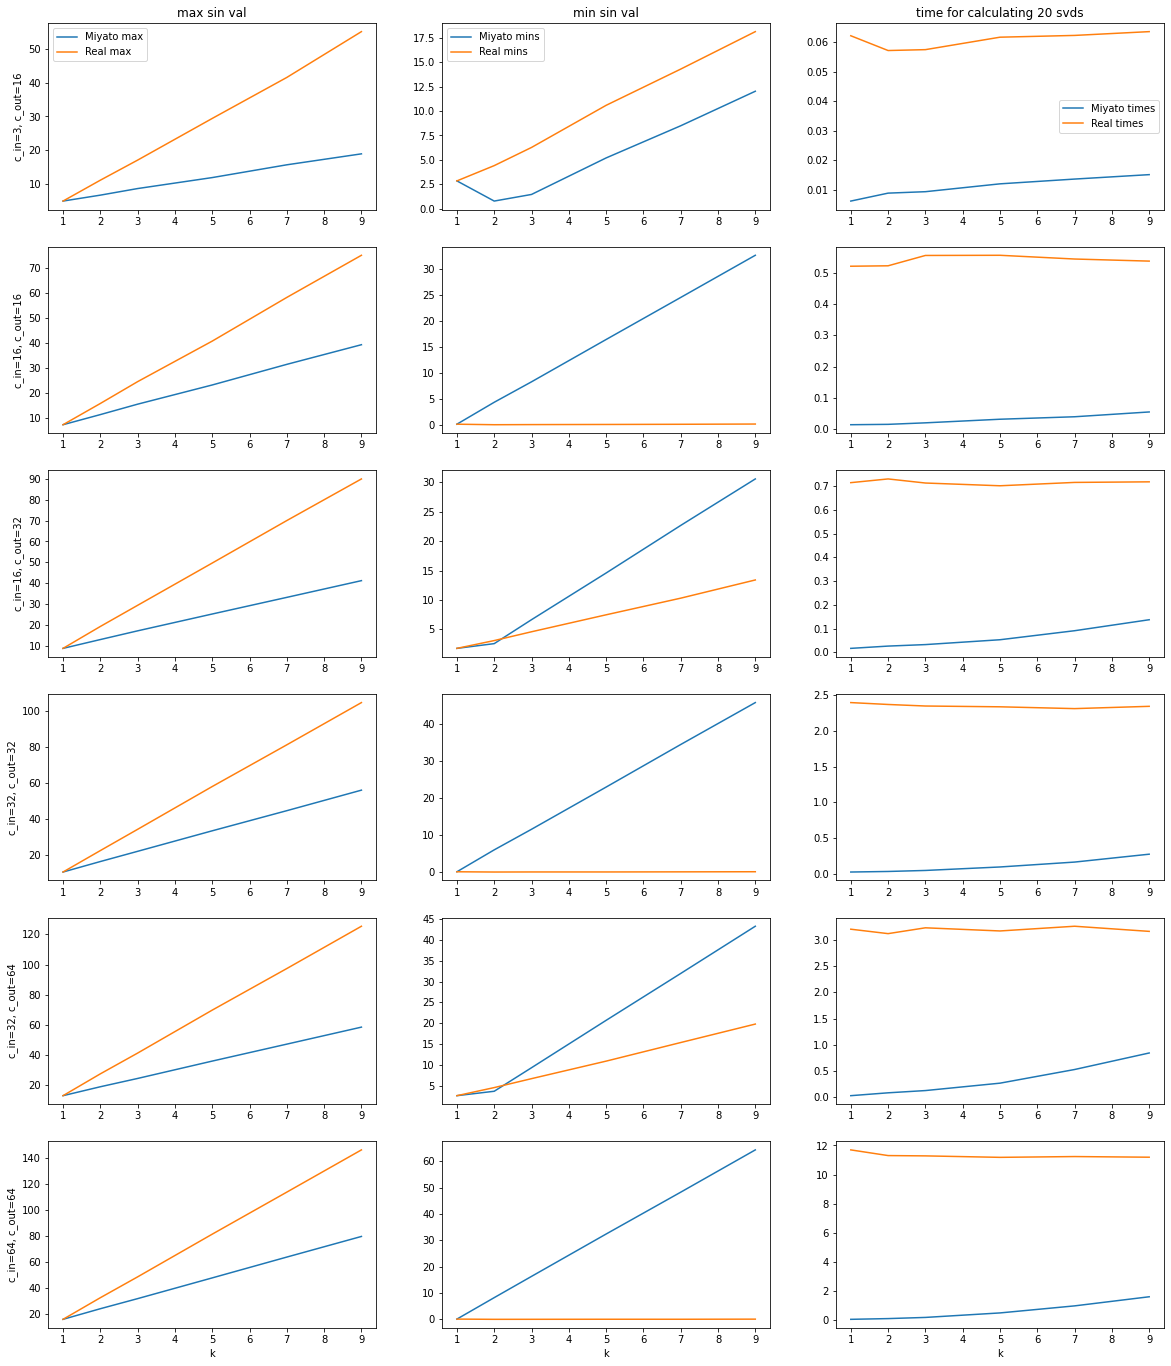

In [ ]:
ks = (1, 2, 3, 5, 7, 9)
fig, axs = plt.subplots(len(cins), 3, figsize=(20, 24))
for i in range(len(cins)):
    min_max_time_sinvals(axs[i], i, ks, cins[i], couts[i])

Resnet 32 weights

In [8]:
from tensorflow import keras
wo_clip = keras.models.load_model('cifar10_ResNet32v1_model.473.h5')
clip_05 = keras.models.load_model('cifar10_ResNet32v1_model.648_clip_05.h5')
clip_1 = keras.models.load_model('cifar10_ResNet32v1_model.646_clip_1.h5')

In [9]:
def width_in(conv): # R
    out_ch, in_ch, h, w = conv.shape
    flat_conv = tf.cast(tf.reshape(tf.transpose(conv, [0, 2, 1, 3]), (out_ch*h, -1)), tf.dtypes.complex128)
    return np.sqrt(h*w) * tf.norm(flat_conv, ord=2, axis=(0, 1))

In [10]:
def width_out(conv): # S
    out_ch, in_ch, h, w = conv.shape
    flat_conv = tf.cast(tf.reshape(tf.transpose(conv, [0, 3, 1, 2]), (out_ch*w, -1)), tf.dtypes.complex128)
    return np.sqrt(h*w) * tf.norm(flat_conv, ord=2, axis=(0, 1))

In [11]:
def out(conv): # T
    out_ch, in_ch, h, w = conv.shape
    flat_conv = tf.cast(tf.reshape(conv, (out_ch, -1)), tf.dtypes.complex128)
    return np.sqrt(h*w) * tf.norm(flat_conv, ord=2, axis=(0, 1))

In [12]:
def wh_out(conv): # U
    out_ch, in_ch, h, w = conv.shape
    flat_conv = tf.cast(tf.reshape(tf.transpose(conv, [0, 2, 3, 1]), (out_ch*h*w, -1)), tf.dtypes.complex128)
    return np.sqrt(h*w) * tf.norm(flat_conv, ord=2, axis=(0, 1))

In [ ]:
est_names = ("R", "S", "T", "U", "real")
est_func = (width_in, width_out, out, wh_out, sedghi_max_sinval)
for i in range(len(wo_clip.layers)):
    layer = wo_clip.layers[i]
    if layer.name.startswith("conv"):
        weights = layer.weights[0]
        weights_tr = tf.transpose(weights, [3, 2, 1, 0])
        print("layer number {}, {} {}".format(i, layer.name, weights.shape))

        sins, tim = est_func[4](weights, layer.input_shape[1:])
        max_sin_real = np.max(sins)
        print("{}: {:.4f}".format(est_names[4], max_sin_real))
        
        for j in range(4):
            max_sin = est_func[j](weights_tr)
            print("{}: {:.4f}\t{:.4f}".format(est_names[j], max_sin, max_sin / max_sin_real))


layer number 1, conv2d (3, 3, 3, 16)
real: 4.2851
R: 7.6641	1.7885
S: 7.4710	1.7435
T: 7.2435	1.6904
U: 9.8358	2.2954
layer number 4, conv2d_1 (3, 3, 16, 16)
real: 3.6891
R: 5.9000	1.5993
S: 6.0428	1.6380
T: 7.3061	1.9805
U: 6.7422	1.8276
layer number 7, conv2d_2 (3, 3, 16, 16)
real: 3.4716
R: 6.4643	1.8620
S: 5.8599	1.6879
T: 6.4519	1.8585
U: 6.9374	1.9983
layer number 11, conv2d_3 (3, 3, 16, 16)
real: 3.6541
R: 5.2377	1.4333
S: 5.1795	1.4174
T: 5.4763	1.4986
U: 5.6714	1.5520
layer number 14, conv2d_4 (3, 3, 16, 16)
real: 3.8913
R: 5.0264	1.2917
S: 4.8479	1.2458
T: 5.2827	1.3576
U: 5.5003	1.4135
layer number 18, conv2d_5 (3, 3, 16, 16)
real: 3.6059
R: 5.1282	1.4222
S: 5.3895	1.4947
T: 5.5384	1.5360
U: 5.9627	1.6536
layer number 21, conv2d_6 (3, 3, 16, 16)
real: 3.9922
R: 4.4556	1.1161
S: 4.5732	1.1456
T: 4.5647	1.1434
U: 4.8234	1.2082
layer number 25, conv2d_7 (3, 3, 16, 16)
real: 3.9780
R: 5.3274	1.3392
S: 6.0297	1.5158
T: 5.1535	1.2955
U: 6.5269	1.6408
layer number 28, conv2d_8 (3, 

In [13]:
est_names = ("R", "S", "T", "U", "real")
est_func = (width_in, width_out, out, wh_out, sedghi_max_sinval)
for i in range(len(clip_1.layers)):
    layer = clip_1.layers[i]
    if layer.name.startswith("conv"):
        weights = layer.weights[0]
        weights_tr = tf.transpose(weights, [3, 2, 1, 0])
        print("layer number {}, {} {}".format(i, layer.name, weights.shape))

        sins, tim = est_func[4](weights, layer.input_shape[1:])
        max_sin_real = np.max(sins)
        print("{}: {:.4f}".format(est_names[4], max_sin_real))
        
        for j in range(4):
            max_sin = est_func[j](weights_tr)
            print("{}: {:.4f}\t{:.4f}".format(est_names[j], max_sin, max_sin / max_sin_real))


layer number 1, conv2d (3, 3, 3, 16)
real: 1.0013
R: 2.1002	2.0975
S: 2.3218	2.3188
T: 1.9465	1.9440
U: 2.7759	2.7724
layer number 4, conv2d_1 (3, 3, 16, 16)
real: 1.0040
R: 2.1000	2.0917
S: 2.0948	2.0865
T: 2.3083	2.2992
U: 2.2869	2.2779
layer number 7, conv2d_2 (3, 3, 16, 16)
real: 1.0033
R: 2.0772	2.0704
S: 2.1445	2.1374
T: 2.2584	2.2510
U: 2.2992	2.2916
layer number 11, conv2d_3 (3, 3, 16, 16)
real: 1.0061
R: 2.1247	2.1119
S: 2.1866	2.1735
T: 2.3919	2.3775
U: 2.2992	2.2853
layer number 14, conv2d_4 (3, 3, 16, 16)
real: 1.0042
R: 2.1709	2.1618
S: 2.0303	2.0217
T: 2.0882	2.0794
U: 2.4467	2.4364
layer number 18, conv2d_5 (3, 3, 16, 16)
real: 1.0037
R: 2.0322	2.0247
S: 1.9804	1.9730
T: 2.1063	2.0984
U: 2.2820	2.2735
layer number 21, conv2d_6 (3, 3, 16, 16)
real: 1.0028
R: 1.7856	1.7806
S: 2.0522	2.0464
T: 2.1469	2.1409
U: 2.0824	2.0766
layer number 25, conv2d_7 (3, 3, 16, 16)
real: 1.0043
R: 1.9433	1.9351
S: 1.9726	1.9642
T: 2.1948	2.1855
U: 2.1941	2.1848
layer number 28, conv2d_8 (3, 